<a href="https://colab.research.google.com/github/punnoose-1620/masters-thesis-sensor-data/blob/main/Intent_Data_Generator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Imports

In [170]:
!pip install tqdm
!pip install seaborn
!pip install matplotlib
!pip install scikit-learn
!pip install sentence-transformers scikit-learn

In [171]:
from sklearn.feature_extraction.text import CountVectorizer
from sentence_transformers import SentenceTransformer
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm
import pandas as pd
import random
import re

# Data Generation and Cross Verification

## Declare Data Parameters and Limits

### 1. Define Brand-Model Mappings (Verified for 2024-2026)

In [172]:
# Structure: {Brand: {Model: [Year Range]}}
AUTOMOTIVE_MAP = {
    "Volvo": {
        "XC90": list(range(2015, 2026)),
        "XC60": list(range(2017, 2026)),
        "EX90": [2024, 2025, 2026],
        "EX30": [2023, 2024, 2025, 2026],
        "S90": list(range(2016, 2026)),
        "V60 Recharge": [2021, 2022, 2023, 2024, 2025],
        "EM90": [2024, 2025]
    },
    "Polestar": {
        "Polestar 2": [2020, 2021, 2022, 2023, 2024, 2025],
        "Polestar 3": [2023, 2024, 2025],
        "Polestar 4": [2024, 2025],
        "Polestar 5": [2025, 2026]
    },
    "Lynk & Co": {
        "01": list(range(2017, 2026)),
        "03 TCR": [2019, 2020, 2021, 2022, 2023, 2024, 2025],
        "05": [2020, 2021, 2022, 2023, 2024, 2025],
        "08 EM-P": [2023, 2024, 2025],
        "09 Ultra": [2021, 2022, 2023, 2024, 2025],
        "Z10": [2024, 2025]
    },
    "Zeekr": {
        "001": [2021, 2022, 2023, 2024, 2025],
        "007": [2023, 2024, 2025],
        "009": [2022, 2023, 2024, 2025],
        "X": [2023, 2024, 2025],
        "7X": [2024, 2025],
        "Mix": [2024, 2025]
    },
    "Jiyue": {
        "01": [2023, 2024, 2025],
        "07": [2024, 2025]
    },
    "Lotus": {
        "Eletre": [2023, 2024, 2025],
        "Emira": [2022, 2023, 2024, 2025],
        "Emeya": [2024, 2025],
        "Evija": [2020, 2021, 2022, 2023, 2024, 2025]
    },
    "Geely Auto": {
        "Starray": [2022, 2023, 2024, 2025],
        "Coolray": [2018, 2019, 2020, 2021, 2022, 2023, 2024, 2025],
        "Geometry E": [2022, 2023, 2024, 2025],
        "Galaxy L7": [2023, 2024, 2025],
        "Panda Mini": [2023, 2024, 2025],
        "Emigrant": [2021, 2022, 2023, 2024, 2025]
    }
}

### 2. Define Technical Sensor/Data Categories

In [173]:
# Replace SENSORS and TOOLS with these to capture regional terminology
SENSORS = [
    "LiDAR", "Lidar", "LIDAR", # Casing variations
    "Tyre Pressure", "Tire Pressure", "TPMS",
    "Boot latch sensor", "Trunk sensor",
    "High Voltage battery", "HV battery", "Traction battery",
    "NVH", "Noise and Vibration", "Acoustics",
    "Bonnet sensor", "Hood sensor",
    "ADAS Camera", "Vision system", "Autonomous sensor",
    "CAN-FD", "CANBUS", "Control Network"
]

SPECIAL_TOOLS = [
    "Kistler Wheels", "Oxford RT3000", "Micro-epsilon",
    "HEAD acoustics", "Roof-mounted rig", "OBD-II logger",
    "CANoe hardware", "Data logger unit"
]

FORMATS = ["MDF4", "Parquet", "CSV", "JSON", "HDF5"]

### 3. Define Intent Templates (Mapped to your 20 Questions)

In [174]:
# Keys are the question numbers from your prompt
TEMPLATES = {
    "data_definition": [
        "What types of {sensor} data are available for {brand} {model}?", # Standard
        "{model} {sensor} data type?",                                   # Shorthand
        "what is {sensor} for {brand}?",                                 # Vague
        "explain {sensor} context in {model}",                           # Engineering
        "why we use {format} for {sensor}?",                             # Format-specific
        "for {model} what {sensor} info exists?",                        # ESL
        "definition of {sensor} telemetry {brand}",                      # Jargon
        "how {sensor} works in {brand} {model}?",                       # Functional
        "what {sensor} means for car {model}?",                          # Simple
        "{sensor} description {brand} {model}"                           # Search-style
    ],
    "temporal_stats": [
        "When did we start collecting {sensor} for {model}?",            # Standard
        "since when {sensor} collected {brand}?",                        # ESL
        "start date for {sensor} logs {model}",                          # Database-style
        "when stop {sensor} for {brand}?",                               # Discontinuation
        "why {sensor} collection discontinued {model}?",                 # Formal
        "last update time for {sensor}",                                 # Recent
        "how long we have {sensor} data for {model}?",                   # Duration
        "first time {sensor} was used in {brand}?",                      # Historical
        "is {sensor} still being recorded for {model}?",                 # Status
        "{sensor} history {brand}"                                       # Keyword-only
    ],
    "statistical_query": [
        "What are the peaks of {sensor} in {brand} {model}?",            # Standard
        "avg value for {sensor} {model}",                                # Shorthand
        "mean {sensor} across {brand} fleet",                            # Aggregated
        "what is highest/lowest {sensor}?",                              # Extremes
        "give me {sensor} max min {model}",                              # Direct
        "common range for {sensor} in {brand}",                          # Normative
        "average reading of {sensor} {model}",                           # Measurement
        "most freq {sensor} value",                                      # Modal
        "peak values {sensor} {model} last week",                        # Time-bounded
        "what is {sensor} average in {brand} {model}?"                   # Question
    ],
    "anomaly_info": [
        "Show me outliers for {sensor} in {model}",                      # Standard
        "why {sensor} spikes in {brand}?",                               # Spikes
        "abnormal {sensor} readings {model}",                            # Global ESL
        "frequency of {sensor} errors {brand}",                          # Quantitative
        "erratic {sensor} data in {model}",                              # Descriptive
        "outlier reason for {sensor} logs",                              # Inquiry
        "why {sensor} data jump so much?",                               # Informal
        "bad data points in {sensor} {model}",                           # Layman
        "identify {sensor} anomalies {brand}",                           # Formal
        "{sensor} glitching on {model}?"                                 # Slang
    ],
    "access_governance": [
        "Who has access to {sensor} logs for {brand}?",                  # Standard
        "who is owner {sensor} data?",                                   # Direct/ESL
        "contact for {model} {sensor} access",                           # Actionable
        "who working on {brand} {sensor} right now?",                    # Collaboration
        "permission for {model} {sensor} data",                          # Credential-based
        "responsible person for {sensor} {brand}",                       # Organizational
        "who updated {sensor} database last?",                           # Audit
        "request access to {model} {sensor}",                            # Formal
        "to whom i speak for {sensor} access?",                          # Formal-ESL
        "who owns the {sensor} dataset?"                                 # Property
    ],
    "collection_method": [
        "Is {sensor} data live for {model}?",                            # Standard
        "does {sensor} need {tool} for collection?",                     # Hardware
        "production vehicle logs for {brand} {sensor}?",                 # Fleet
        "special attachments for {model} {sensor}?",                     # Equipment
        "is {sensor} real-time or offline?",                             # Latency
        "must use {tool} for {brand} data?",                             # Requirement
        "collected after release for {model}?",                          # Lifecycle
        "roof rig needed for {sensor}?",                                 # Visual hardware
        "how is {sensor} data gathered for {brand}?",                    # General
        "is {model} {sensor} streaming?"                                 # Modern tech
    ],
    "comparative_analysis": [
        "compare {sensor} between {model} and {model_alt}",
        "difference in {sensor} data for {brand} vs {brand_alt}",
        "is {sensor} more accurate in {model} or {model_alt}?",
        "{sensor} performance {brand} vs {brand_alt}"
    ],
    "system_status_check": [
        "check {brand} {sensor} database health",
        "is {sensor} data stream broken for {model}?",
        "status of {sensor} collection in {brand}",
        "any issues with {sensor} logs today?"
    ],
    "imperative_commands": [
        "get me {sensor} stats for {model}",
        "show {brand} {sensor} owner now",
        "find outliers in {sensor} dataset",
        "pull {sensor} history for {model}"
    ],
    "contextual_followups": [
        "what about {sensor} on the {model}?",
        "same info but for {brand} {model}",
        "tell me more about {sensor} context",
        "why stop? ({sensor})"
    ]
}

### 4. ROBUSTNESS & NOISE GENERATOR

In [175]:
def inject_noise(text):
    chance = random.random()
    # 1. Lowercase + No Punctuation (Shorthand)
    if chance < 0.15:
        text = text.lower().replace("?", "").replace(".", "")
    # 2. Keyboard Typos
    elif chance < 0.25:
        typo_map = {"a": "q", "e": "r", "i": "o", "s": "x"}
        for c in text:
            if c in typo_map and random.random() > 0.8:
                text = text.replace(c, typo_map[c], 1)
                break
    # 3. Omit brand (Internal assumption)
    elif chance < 0.35:
        for brand in AUTOMOTIVE_MAP.keys():
            text = text.replace(brand + " ", "")
    return text

### 5. Functions to Make sure query contains 2 different cars

In [176]:
def get_sameModel_diffYear(brand, model, year):
  year_alt = random.choice(AUTOMOTIVE_MAP[brand][model])
  while year_alt==year:
    year_alt = random.choice(AUTOMOTIVE_MAP[brand][model])
  return brand, model, year_alt

In [177]:
def get_sameBrand_diffModel(brand, model, year):
  model_alt = random.choice(list(AUTOMOTIVE_MAP[brand].keys()))
  while model_alt==model:
    model_alt = random.choice(list(AUTOMOTIVE_MAP[brand].keys()))
  if year not in AUTOMOTIVE_MAP[brand][model_alt]:
    year_alt = random.choice(AUTOMOTIVE_MAP[brand][model_alt])
    return brand, model_alt, year_alt
  return brand, model_alt, year

In [178]:
def get_diffBrand(brand, model, year):
  brand_alt = random.choice(list(AUTOMOTIVE_MAP.keys()))
  while brand_alt==brand:
    brand_alt = random.choice(list(AUTOMOTIVE_MAP.keys()))
  model_alt = random.choice(list(AUTOMOTIVE_MAP[brand_alt].keys()))
  if year not in AUTOMOTIVE_MAP[brand_alt][model_alt]:
    year_alt = random.choice(AUTOMOTIVE_MAP[brand_alt][model_alt])
    return brand_alt, model_alt, year_alt
  return brand_alt, model_alt, year

In [179]:
def get_second_vehicle(brand, model, year):
  functions = [
      (get_sameModel_diffYear, [brand, model, year], 'Same Model, Different Year'),
      (get_sameBrand_diffModel, [brand, model, year], 'Same Brand, Different Model'),
      (get_diffBrand, [brand, model, year], 'Different Brand')
  ]

  chosen_func, args, description = random.choice(functions)
  # print(f"Selected Function: {description}")
  return chosen_func(*args)

## Function to Generate Dataset

In [180]:
def generate_dataset(target_size=7500):
    dataset = []
    seen = set()
    run_count = 0

    brands = list(AUTOMOTIVE_MAP.keys())

    with tqdm(total=target_size, desc='Generating Dataset....') as pbar:
      while len(dataset) < target_size:
          brand_value = random.choice(brands)
          model_value = random.choice(list(AUTOMOTIVE_MAP[brand_value].keys()))
          year_value = random.choice(AUTOMOTIVE_MAP[brand_value][model_value])
          sensor_value = random.choice(SENSORS)
          tool_value = random.choice(SPECIAL_TOOLS)
          fmt_value = random.choice(FORMATS)

          brand_alt_value, model_alt_value, year_alt_value = get_second_vehicle(brand_value, model_value, year_value)

          intent_value = random.choice(list(TEMPLATES.keys()))
          template_value = random.choice(TEMPLATES[intent_value])

          # print('\nLOG: Testing Values....')
          # print('\tBrand: ', brand_value)
          # print('\tModel(Year): ', f"{model_value}({year_value})")
          # print('\tSensor: ', sensor_value)
          # print('\tTool: ', tool_value)
          # print('\tFMT: ', fmt_value)
          # print('\tIntent: ', intent_value)
          # print('\tTemplate: ', template_value)

          raw_query = template_value.format(
              brand=brand_value, model=model_value, year=year_value,
              sensor=sensor_value, tool=tool_value, format=fmt_value,
              model_alt=model_alt_value, brand_alt=brand_alt_value, year_alt=year_alt_value
          )

          # print(f"LOG: Raw Query : {raw_query}\n")

          query = inject_noise(raw_query)
          run_count += 1
          # print(f"LOG: Run Count : {run_count}\n")

          if raw_query not in seen:
              dataset.append({
                  "query": query,
                  "intent": intent_value,
                  "brand": brand_value,
                  "model": model_value,
                  "year": year_value,
                  "sensor": sensor_value
              })
              seen.add(raw_query)
              pbar.update(1)
    print(run_count, 'Generation Cycles Completed')
    return pd.DataFrame(dataset)

## Generate and Save Dataset

In [181]:
df = generate_dataset(7500)
df.to_csv("geely_group_internal_dataset.csv", index=False)
print(f"Success! Generated {len(df)} unique entries for automotive sensor intent model.")

Generating Dataset....: 100%|██████████| 7500/7500 [00:00<00:00, 31329.67it/s]


12085 Generation Cycles Completed
Success! Generated 7500 unique entries for automotive sensor intent model.


# Data Analysis and Visualization

## Intent Distribution Graph

Checks distribution of queries across intents to make sure this isn't biased towards any single intent.

In [182]:
def plot_intent_distribution(df):
    plt.figure(figsize=(12, 6))
    sns.countplot(data=df, y='intent', order=df['intent'].value_counts().index, palette='viridis')
    plt.title('Distribution of Intents (Class Balance Check)')
    plt.xlabel('Number of Samples')
    plt.ylabel('Intent Label')
    plt.tight_layout()
    plt.show()

## N-Gram Frequency Analysis

This creates 2 charts: one for single words (Unigrams) and one for two-word phrases (bigrams) to see which technical terms dominate

In [183]:
def plot_ngram_frequency(df, n=2, top_k=20):
    fig, axes = plt.subplots(1, 2, figsize=(18, 8))

    for i, gram_size in enumerate([1, 2]):
        vec = CountVectorizer(ngram_range=(gram_size, gram_size), stop_words='english').fit(df['query'])
        bag_of_words = vec.transform(df['query'])
        sum_words = bag_of_words.sum(axis=0)
        words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
        words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)[:top_k]

        words, counts = zip(*words_freq)
        sns.barplot(x=list(counts), y=list(words), ax=axes[i], palette='magma')
        axes[i].set_title(f'Top {top_k} {"Unigrams" if gram_size==1 else "Bigrams"}')

    plt.tight_layout()
    plt.show()

## Query Length and Complexity Analysis

This analyzes word counts and character counts to ensure the model handles both "telegraphic" shorthand and "verbose" queries

In [184]:
def plot_query_complexity(df):
    df['word_count'] = df['query'].apply(lambda x: len(x.split()))
    df['char_count'] = df['query'].apply(len)

    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    sns.histplot(df['word_count'], bins=20, kde=True, ax=axes[0], color='skyblue')
    axes[0].set_title('Distribution of Word Counts')

    sns.histplot(df['char_count'], bins=20, kde=True, ax=axes[1], color='salmon')
    axes[1].set_title('Distribution of Character Counts')

    plt.tight_layout()
    plt.show()

## Embedding Visualization

This uses t-SNE to project the high-dimensional text data into 2D. If the cluster overlaps too much, the intents are likely to be too similar.

In [185]:
def plot_embeddings(df):
    # Using a lightweight model for speed
    model = SentenceTransformer('all-MiniLM-L6-v2')
    embeddings = model.encode(df['query'].tolist(), show_progress_bar=True)

    # Reduce dimensions to 2D
    tsne = TSNE(n_components=2, random_state=42, perplexity=30)
    reduced_data = tsne.fit_transform(embeddings)

    plt.figure(figsize=(12, 8))
    sns.scatterplot(x=reduced_data[:, 0], y=reduced_data[:, 1], hue=df['intent'],
                    palette='tab10', s=10, alpha=0.6)
    plt.title('t-SNE Visualization of Query Embeddings by Intent')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

## Heatmap for Parameter Coverage Visualization

This checks if every brand is adequately represented across every intent, highlighting any "data holes".

In [186]:
def plot_parameter_coverage(df):
    # Pivot table of Brand vs Intent
    coverage = pd.crosstab(df['brand'], df['intent'])

    plt.figure(figsize=(14, 7))
    sns.heatmap(coverage, annot=True, fmt="d", cmap="YlGnBu")
    plt.title('Parameter Coverage: Brands vs. Intents')
    plt.xlabel('Intent')
    plt.ylabel('Brand')
    plt.tight_layout()
    plt.show()

## Running Data Analysis

/tmp/ipython-input-354434878.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, y='intent', order=df['intent'].value_counts().index, palette='viridis')


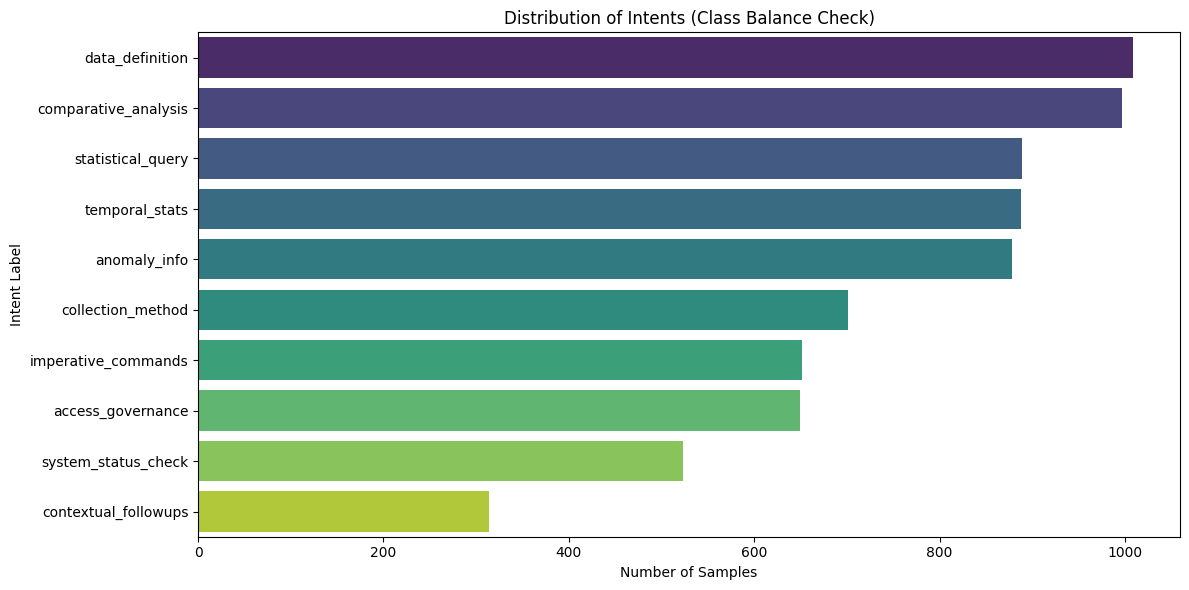

In [187]:
plot_intent_distribution(df)

/tmp/ipython-input-3752421899.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(counts), y=list(words), ax=axes[i], palette='magma')
/tmp/ipython-input-3752421899.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(counts), y=list(words), ax=axes[i], palette='magma')


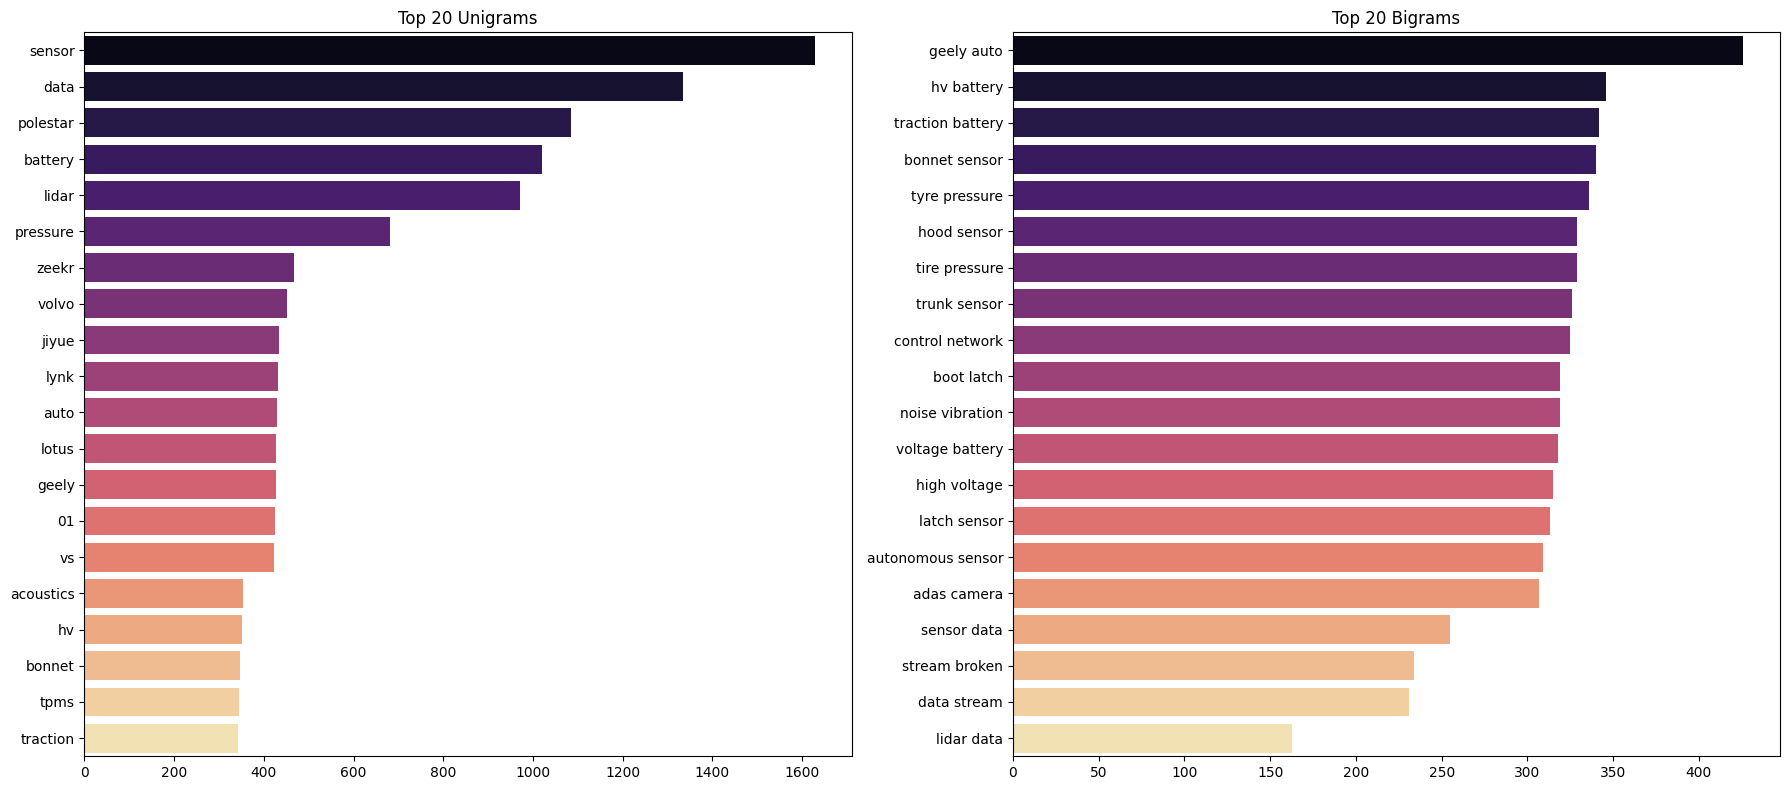

In [188]:
plot_ngram_frequency(df)

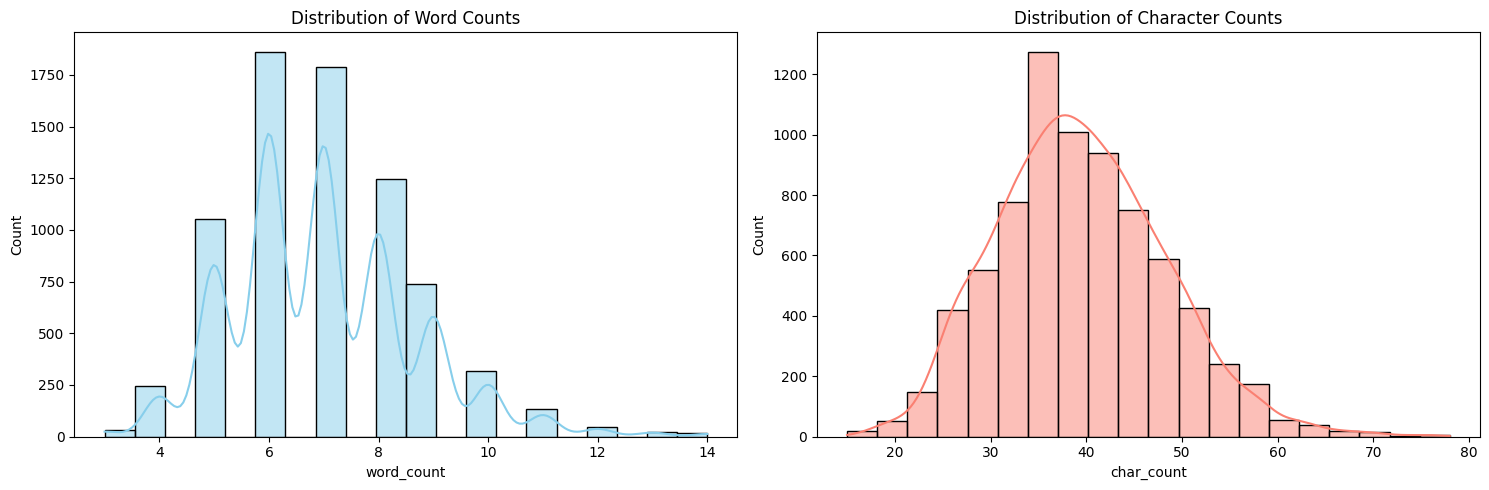

In [189]:
plot_query_complexity(df)

Batches:   0%|          | 0/63 [00:00<?, ?it/s]

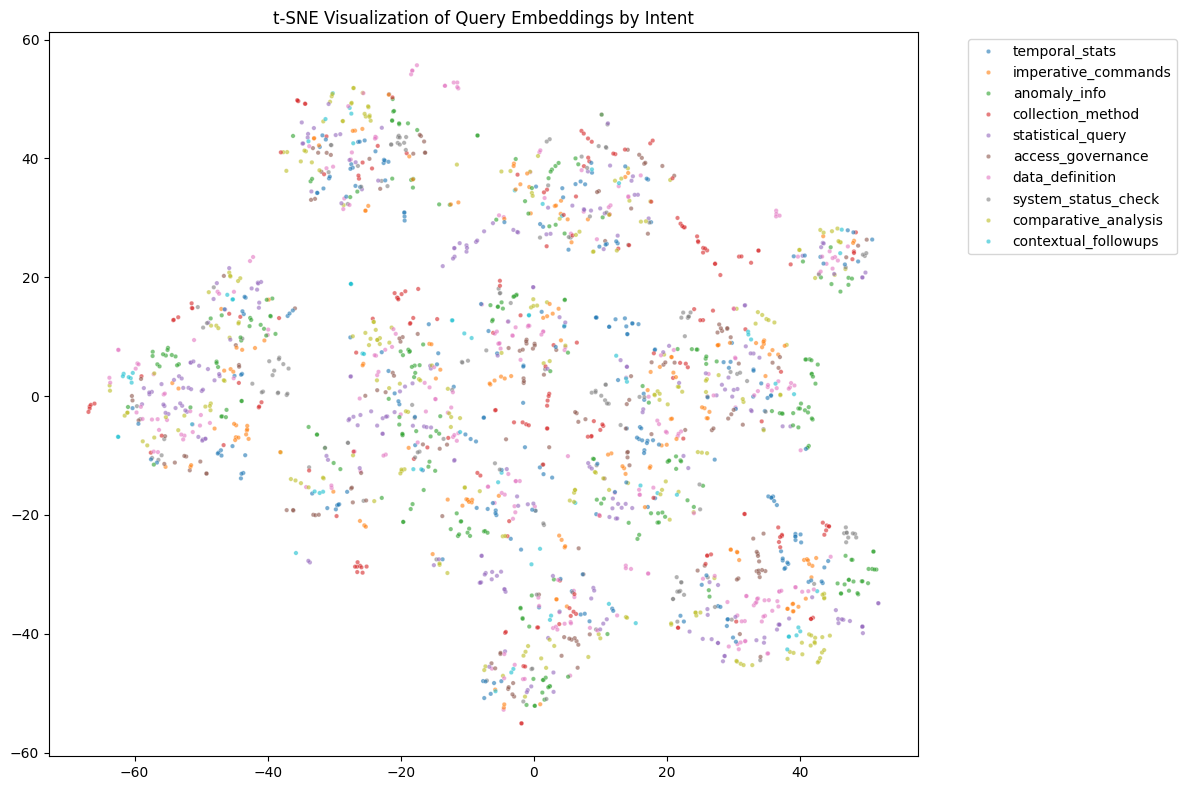

In [190]:
plot_embeddings(df.sample(2000)) # Subsample for faster t-SNE plotting

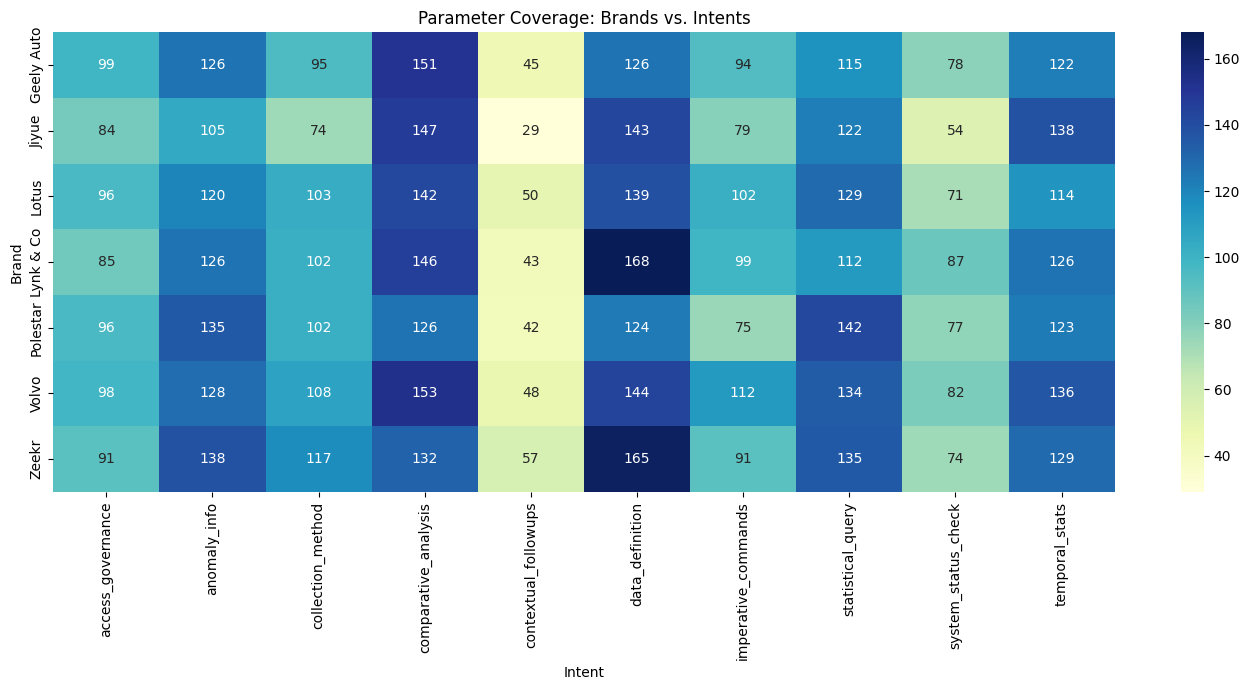

In [191]:
plot_parameter_coverage(df)